# Sample farm layout

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/ascldap/users/lcheung/wind_uq/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
    
# Load the libraries
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt
import numpy as np
import math

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline


/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Rotates a point pt about origin orig   
# Here theta is measured w.r.t. the x-axis
def rotatepoint(pt, orig, theta):
    dx = pt[0]-orig[0]
    dy = pt[1]-orig[1]
    p2=[0.0, 0.0]
    p2[0] = dx*math.cos(theta) - dy*math.sin(theta) + orig[0]
    p2[1] = dx*math.sin(theta) + dy*math.cos(theta) + orig[1]
    return p2

def removeturbines(runcase):
    physics = runcase.getAMRWindInput('incflo.physics')
    if 'Actuator' in physics:
        physics.remove('Actuator')
        runcase.setAMRWindInput('physics', physics)
        print('SET incflo.physics: '+repr(runcase.getAMRWindInput('incflo.physics')))
    runcase.setAMRWindInput('ActuatorForcing', False)    
    runcase.listboxpopupwindict['listboxactuator'].deleteall()
    return

In [3]:
# Define some properties
rotorD = 127           # Rotor diameter
WS     = 5            # Wind speed, m/s
WDir   = 225           # Wind direction, degrees

# Farm properties
farm_rotate      = -45                          # Number of degrees to rotate turbine rows (relative to x-axis)

# ==== 50 turbine staggered arrangement ====
farm_title       = 'IEA 15MW, 28 turbine staggered arrangement'
# Turbine spacing
turb_LatSpacing  = 3   # lateral spacing, diameters
turb_LongSpacing = 8   # longitudinal spacing, diameters
# Define the rows
farmrowdict = [{'Nturb':4, 'rowoffset':0},
               {'Nturb':3, 'rowoffset':1.5},
               {'Nturb':4, 'rowoffset':0},
               #{'Nturb':5, 'rowoffset':1.5},
               #{'Nturb':6, 'rowoffset':0},
               #{'Nturb':5, 'rowoffset':1.5},
               #{'Nturb':6, 'rowoffset':0},
               #{'Nturb':5, 'rowoffset':1.5},
               #{'Nturb':6, 'rowoffset':0},
              ]

farmturb_orig    = [0, 0]
farmL            = 3840.0
farm_domainsize  = [2*farmL, 2*farmL, 1920.0]   # Farm domain size
farm_background_mesh = 20.0                     # Background mesh size [meters]

In [4]:
# Build the wind farm turbine positions
farmturb_xy = []
for irow, row in enumerate(farmrowdict):
    turb_y = irow*turb_LongSpacing*rotorD
    for iturb in range(row['Nturb']):
        turb_x = iturb*turb_LatSpacing*rotorD + row['rowoffset']*rotorD
        farmturb_xy.append([turb_x, turb_y])
farmturb_xy = np.array(farmturb_xy)

print("Total turbines = "+repr(len(farmturb_xy)))

# Recenter the farm to be at the origin
farmturb_0 = np.mean(farmturb_xy, axis=0)
farmturb_xy = np.array([x-farmturb_0 for x in farmturb_xy])
farmturb_xy = np.array([rotatepoint(pt, [0.0, 0.0], farm_rotate*np.pi/180.0) for pt in farmturb_xy])
farmturb_xy = np.array([x+farmturb_orig for x in farmturb_xy])

Total turbines = 11


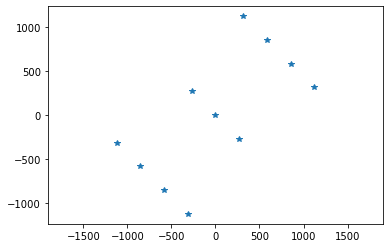

In [5]:
# Test plot
plt.plot(farmturb_xy[:,0], farmturb_xy[:,1], '*')
plt.axis('equal');

## Set up the case

In [6]:
# Start the case
case = amrwind.MyApp.init_nogui()

In [7]:
# Set the time constants
case.setAMRWindInput('time.stop_time', 30000.0)
case.setAMRWindInput('time.max_step',  -1)

case.setAMRWindInput('time.fixed_dt',  0.02) #0.25)
case.setAMRWindInput('time.checkpoint_interval',  5000)

In [8]:
# Set some basic parameters
case.setAMRWindInput('incflo.physics',      ['ABL'])  # Must have ABL physics to do ABL calculations
case.setAMRWindInput('incflo.verbose',      3)        # This is optional, verbose=3 means more info in the output logs
case.setAMRWindInput('io.check_file',       'chk')    # What to name the checkpoint files

case.setAMRWindInput('incflo.use_godunov',  True)       # Always use a godunov scheme
case.setAMRWindInput('incflo.godunov_type', 'weno_z')   # Use 'weno_z' 

case.setAMRWindInput('turbulence.model',    ['OneEqKsgsM84'])    # One equation k-sgs subgrid scale model
case.setAMRWindInput('TKE.source_terms',    ['KsgsM84Src'])      # The corresponding source term

case.setAMRWindInput('transport.viscosity', 1.771e-05)           # dynamic viscosity, based on median air temperature of 284.47 K from 2 m above E06, units Pa-s
case.setAMRWindInput('incflo.density',      1.2456)                # density, based on 1017.13*100./(284.47)/287.058 where 1017.13 is median air pressure from 2 m above E06 and 284.47 is median air temperature from 2 m above E06, units kg/m^3

In [9]:
# Set the wind speed and direction
case.setAMRWindInput('useWSDir', True)                           # Allows you to specify wind speed + wind direction 
case.setAMRWindInput('ABL_windspeed', WS, forcechange=True)     # Wind speed, unites m/s VARY THIS
case.setAMRWindInput('ABL_winddir',   WDir, forcechange=True)     # Wind direction of 225 degrees, from S-W
case.ABL_calculateWindVector()

In [10]:
# Set some tolerances (leave this alone)
tols = """
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol                       = 1e-12               
mac_proj.mg_rtol                         = 1e-06               
mac_proj.mg_atol                         = 1e-12               
diffusion.mg_rtol                        = 1e-06               
diffusion.mg_atol                        = 1e-12               
temperature_diffusion.mg_rtol            = 1e-10               
temperature_diffusion.mg_atol            = 1e-13               
"""
case.loadAMRWindInput(tols, string=True);

In [11]:
turbinetype = case.get_default_turbinetypedict()

turbinetype['turbinetype_name'] = 'DummyGE127'
turbinetype['Actuator_type']    = 'UniformCtDisk'
turbinetype['Actuator_rotor_diameter']     = rotorD
turbinetype['Actuator_hub_height']         = 90.0
turbinetype['Actuator_epsilon']            = [2.5]
turbinetype['Actuator_output_frequency']   = 1
turbinetype['Actuator_diameters_to_sample']= 5.0 
turbinetype['Actuator_num_points_r']       = 20
turbinetype['Actuator_num_points_t']       = 3
turbinetype['Actuator_thrust_coeff']       = 0.2
case.add_populatefromdict('listboxturbinetype', turbinetype)

In [12]:
# Build the CSV input file of turbine layouts for amrwind-frontend
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
"""
rowformat="T%02i, %f, %f, DummyGE127, , ,\n"
for iturb, xy in enumerate(farmturb_xy):
    turbinescsv += rowformat%(iturb, xy[0], xy[1])
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [13]:
# Set up the domain 
case.setAMRWindInput('turbines_domainsize', farm_domainsize)
case.setAMRWindInput('turbines_backgroundmeshsize', farm_background_mesh)
case.setAMRWindInput('turbines_autocalccenter', False)
case.setAMRWindInput('turbines_farmcenter', [0, 0])
case.setAMRWindInput('turbines_deleteprev', True)

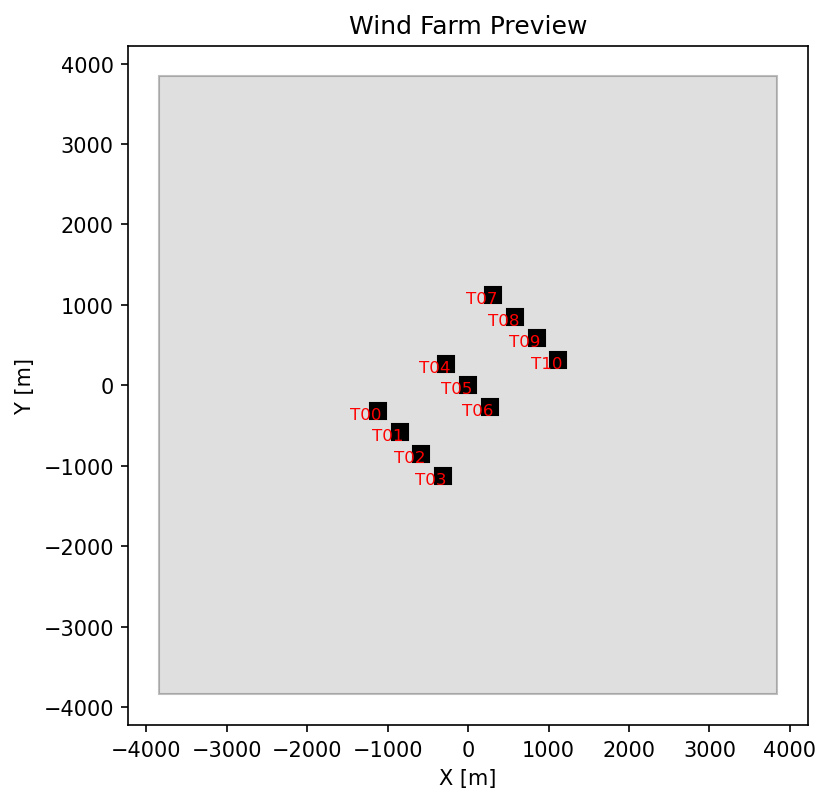

In [14]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

In [15]:
case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()
['T00', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07', 'T08', 'T09', 'T10']


In [16]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     2000,     3000,       1500,    150,   200,     center:specified units:meter centerx:0 centery:0 centerz:90 name:A
1,     1.0,      1.0,        1.0,     0.8,   0.8,
2,     0.5,      0.5,        0.5,     0.525, 0.525,
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)
case.refine_createAllZones()

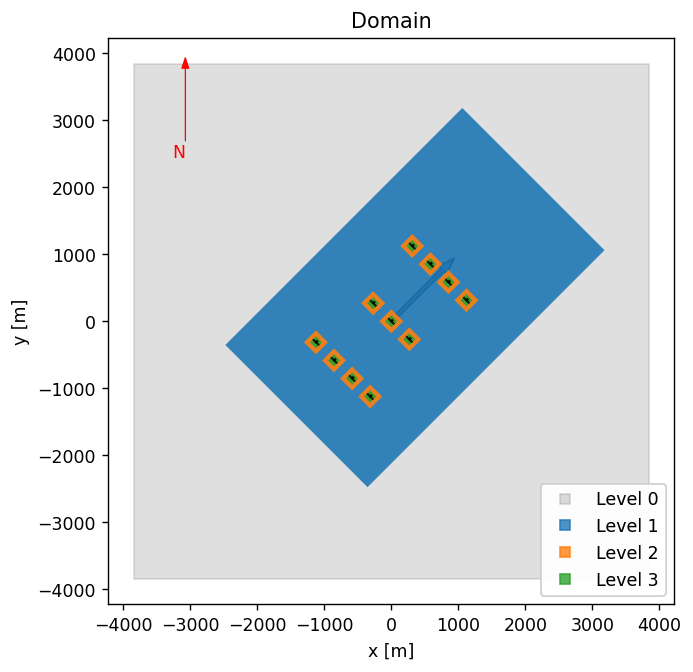

In [17]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
case.plotDomain(ax=ax)

In [18]:
# This will print out your mesh size & refinements
case.estimateMeshSize()

Refinement A: level 1: 5250000 cells
Refinement T00_level_1_zone: level 2: 104877 cells
Refinement T01_level_1_zone: level 2: 104877 cells
Refinement T02_level_1_zone: level 2: 104877 cells
Refinement T03_level_1_zone: level 2: 104877 cells
Refinement T04_level_1_zone: level 2: 104877 cells
Refinement T05_level_1_zone: level 2: 104877 cells
Refinement T06_level_1_zone: level 2: 104877 cells
Refinement T07_level_1_zone: level 2: 104877 cells
Refinement T08_level_1_zone: level 2: 104877 cells
Refinement T09_level_1_zone: level 2: 104877 cells
Refinement T10_level_1_zone: level 2: 104877 cells
Refinement T00_level_2_zone: level 3: 137651 cells
Refinement T01_level_2_zone: level 3: 137651 cells
Refinement T02_level_2_zone: level 3: 137651 cells
Refinement T03_level_2_zone: level 3: 137651 cells
Refinement T04_level_2_zone: level 3: 137651 cells
Refinement T05_level_2_zone: level 3: 137651 cells
Refinement T06_level_2_zone: level 3: 137651 cells
Refinement T07_level_2_zone: level 3: 137651 